<a href="https://colab.research.google.com/github/jrcendagorta/MEP_ReinforcementLearning/blob/master/A2C_2D_SteepDesipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magellan Meets Helmholtz: An Exploration Reinforcement Learning Agent for Landmark Navigation on Free Energy Surfaces

This project is the onset in developing a reinforcement learning agent capable of exploring high-dimensional free energy surfaces (HDFES) and locating important landmarks.

Background on Free Energy Surfaces:

While the absolute free energy provides a central avenue to obtain other thermodynamic properties, \textit{differences} in free energy between two or more thermodynamic states highlight important chemical and physical phenomena.
In this thesis, two categories of free energy differences are explored: thermodynamics states with varying potential energy functions and ``rare" event sampling. free energy landscapes that are functions of the collective variables; differences in free energies among multiple configurations can be determined from these landscapes.

The term, "landscapes," used for free energy surfaces arises from 2D free energy surfaces. The following is an example of a 2D free energy surface. This mirrors a topological map of hills and valleys that one would use for hiking. However, as the dimensionality of the free energy surface, this description is inadequate and a more representative picture is an interconnected web of confiugrational states connected by narrow channels. 

Goals of Research:

First, I want to develop a simple RL agent capable of navigating a simple FES by determining the MEP. 

Ultimately, an agent would want to explore uknown surfaces without knowledge of the varying configurational states. Thus an agent capable of determining both the minima and index-1 saddle points as well as the paths connecting them. To acheive this, an agent must adapt to multiple environment and have an intrinsic reward system to promote exploration. Currently, the research into these types of agents are still limited and thus novel methods will need to be explored. 

Implications:



Version 0.1: 


> Development of a discrete free energy environment and an advantage actor critic agent (A2C) to determine the minimum energy path. This is still under development as the extrinsic reward system does not reporduce the MEP. 


> A continous A2C may be the solution since a bidirectional discrete step size may limit full exploration of the free energy space. Also too small of a step size would lead to long exploration times with minimal reward during exploration, which is a pitfall of the current implementation of A2C. Curiosity-driven (intrinsic rewards) would be a potential solution to smaller step sizes





In [16]:
import os
import gym
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import threading
import multiprocessing
import numpy as np
from queue import Queue
import argparse
import matplotlib.pyplot as plt
import logging

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers, losses, optimizers
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import random
import math
from matplotlib  import cm
from matplotlib import colors

from gym import spaces, logger


0.0
[-1.0, -1.0, 0.0, 0.0, 0.0]
[0.04910000000000003, 0.041100000000000025, 0.0050000000000000044, 0.0050000000000000044]


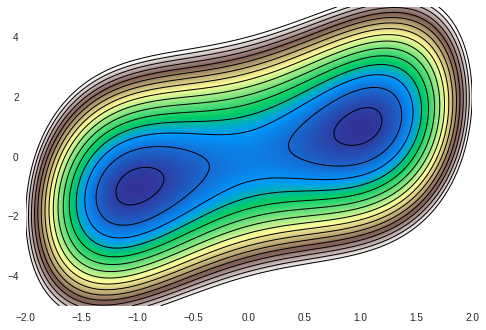

In [17]:

def en_grad(x,y):
  """
  The Potential Energy Surfaces (PES) for a toy 2-dimensional double well problem
  Functional form V(x,y) = A*(x**2 - (x_0)**2) - C*X*Y + 0.5*B*Y**2

  The function returns an energy value and two gradient values of type float.
  """
  C = 1.0
  A = 1.0
  X0 = 1.0
  B = 1.0
  D = 1.0


  X2 = np.square(x)
  Y2 = np.square(y)
  XY = np.multiply(x,y)
  energy = A*np.square(X2-X0*X0)-C*XY+0.5*B*Y2+0.5*D*X2
  dx = 4.0*A*np.multiply(x,X2-X0*X0) - C*y+ D*x
  dy = -C*x + B*y
    
  return energy, dx, dy

colormap = plt.cm.terrain
size=201
levels = np.linspace(-1.0, 9.0, 18)
x=np.linspace(-2, 2,size)
y=np.linspace(-5, 5,size)
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
e,dx,dy=en_grad(xv,yv)
print(np.min(e))
normalize1 = colors.Normalize(vmin=np.min(e), vmax=9)
plt.scatter(xv,yv,c=e,cmap = colormap,norm=normalize1,marker='o',s=20)
#plt.contourf(xv,yv,e,levels=levels)
plt.contour(xv,yv,e,levels=levels,colors=('k',),
                  linewidths=(1,))
plt.xlim(-2,2)
plt.ylim(-5,5)

x = -1.0
y = -1.0
e,dx,dy = en_grad(x,y)
step_size = 0.1
e1, dx1, dy1 = en_grad(x-step_size,y)
e2, dx2, dy2 = en_grad(x+step_size,y)
e3, dx3, dy3 = en_grad(x,y+step_size)
e4, dx4, dy4 = en_grad(x,y-step_size)

ener = [e1-e, e2-e, e3-e, e4-e]
#ener_a = [abs(e1), abs(e2), abs(e3), abs(e4)]
print([x,y,dx,dy,e])
print(ener)








In [21]:
class MEPEnv:
  """
  Description: 
    A 2D potential energy surface (PES) containing two minima and one index-1 
    saddle point. The agent starts at one minimum and the goal is to reach the 
    saddle point and then the next minimum using the path of least resistance.
  
  Attributes:
    step_size : float
      value of each step performed by action (< 1.0)
    method: str
      alogirthm for path generation
      sa - steepest ascent
      sd - steepest descent
   
  Source:
    The original functional form of the PES is adapted from:
    V.A. Benderskii, et al. Chemical Physics, 198, 281-295 (1995)
  
  Observation:
    Type: 2D Numpy array
    Num    Observation       Min       Max
     0      X-position       -3.0      0.5
     1      Y-position       -3.0      0.5
     2      X-gradient       -inf      +inf
     3      Y-gradient       -inf      +inf

  Actions:
   Num   Action
    0    Move left  (x - ds) by user-defined step size
    1    Move right (x + ds) by user-defined step size
    2    Move up    (y + ds) by user-defined step size
    3    Move down  (y - ds) by user-defined step size
  
  Reward:
    Depending on if the user wants a Steepest Descent or (Steepest Ascent Path):
      +10.00 if reach energy minimum (saddle point)
      -00.01 if makes moves leads to positive gradients in both direction
      -00.30 if moves leads to at least one negative gradient
      -00.10 if moves leads to a state already visited
      -00.30 if moves are outside bounds 


    Additional Penalties
    -0.30 goes outside boundaries
    -0.20 moves to a region already visited

  Starting State:
    All observations begin at the saddle point (0,0) for Steepest Descent
    All observations begin at the left energy minimum (-1,-1) for Steepest Ascent

  Episode Termination:
      Reaches end point minima (or saddle point)

  TODO:
    1) Add exception handling for edge cases
    2) Develop continous version of environment
    3) Update reward system, still not producing optimal path

    
  """
  def __init__(self, step_size,method):
    self.step_size = step_size
    self.xmin = -1.0
    self.ymin = -1.0
    self.xsad = 0.0
    self.ysad = 0.0    
    self.memory = []
    self.actions = [0,1,2,3]
    self.reset()
     
    self.energy,self.dx,self.dy = self.en_grad(self.x0,self.y0)
    self.observation_space = self.get_state()
    self.method = method

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]
  
  
  def get_state(self):
    """
    Return the observation state as numpy array
    """
    return np.array([self.x0,self.y0,self.dx,self.dy])

  def reset(self):
    """
    Resets the environment and returns the original state
    """
    self.reward = 0.0
    self.memory = []
    self.done = False
    self.x0 = self.xsad
    self.y0 = self.ysad
    self.energy,self.dx,self.dy = self.en_grad(self.x0,self.y0)
    return self.get_state()

      
  def get_reward(self, action):
    """ 
    Returns the reward for a specific action.
    """
    xtemp = self.x0
    ytemp = self.y0
    
  
    if(action == 0):
        xtemp -= self.step_size
    if(action == 1):
        xtemp += self.step_size
    if(action == 2):
        ytemp += self.step_size
    if(action == 3):
        ytemp -= self.step_size
    
    etemp,temp_dx,temp_dy = self.en_grad(xtemp,ytemp)
    deltaE = etemp - self.energy


    self.memory.append([self.x0,self.y0])
    self.x0 = xtemp
    self.y0 = ytemp
    self.energy = etemp
      
    if temp_dx > 0 and temp_dy > 0:
      self.reward = -0.01
    else:
      self.reward = -0.3

    if [self.x0,self.y0] in self.memory :
      self.reward = -0.1

    if self.method == 'sd':
      if (abs(self.x0-self.xmin) < self.step_size/10.0) and (abs(self.y0-self.ymin) < self.step_size/10.0):
        self.reward = 10.0
        self.done = True
    elif self.method == 'sa':
       if (abs(self.x0-self.xsad) < self.step_size/10.0) and (abs(self.y0-self.ysad) < self.step_size/10.0):
        self.reward = 10.0
        self.done = True 


    if self.x0 < -3.0 or self.y0 < -3.0 or self.x0 > 0.5 or self.y0 > 0.5:
      self.reward = -0.3


    return self.reward
          
  def get_done(self):
    """
    Return if environment has terminated
    """
    return self.done
  
  def end_sess(self):
    """
    Manually forces the environment to terminate.
    Useful if number of steps exceeds a defined value
    """
    self.done = True
    return self.done
  
  def step(self,action):
    """
    Performs designated action.
    """
    reward = self.get_reward(action)
    done = self.get_done()
    state = self.get_state()
    return state, reward, done, {}
  
  def action_sample(self):
    """
    Sample a random action. Useful for random agents
    """
    return random.sample(self.actions,1)[0]

  def en_grad(self,x,y):
    """
    The Potential Energy Surfaces (PES) for a toy 2-dimensional double well problem
    Functional form V(x,y) = A*(x**2 - (x_0)**2) - C*X*Y + 0.5*B*Y**2

    The function returns an energy value and two gradient values of type float.
    """
    C = 1.0
    A = 1.0
    X0 = 1.0
    B = 1.0
    D = 1.0

    X2 = np.square(x)
    Y2 = np.square(y)
    XY = np.multiply(x,y)
    energy = A*np.square(X2-X0*X0)-C*XY+0.5*B*Y2 + 0.5*D*X2
    dx = 4.0*A*np.multiply(x,X2-X0*X0) - C*y + D*x
    dy = -C*x + B*y
    cosx, cosy = self.transform_gradients(dx,dy)
      
    return energy, dx, dy
    
  def transform_gradients(self,dx,dy):
    """
    Method to transform gradients to the range of [-1,1]. The gradients are weighted
    by a constant to approximate the relation between changes in distance to changes 
    in energy (i.e. 1 unit in energy change will equal 1 unit in distance x or y).

    The function returns to the transformed gradients
    """
    const = self.step_size
    hx = np.sqrt(np.square(dx*const)+self.step_size)
    hy = np.sqrt(np.square(dy*const)+self.step_size)

    cosx = np.divide(dx,hx)
    cosy = np.divide(dy,hy)

    return cosx,cosy

  def get_action_name(self,action):
    """
    Return the encoded action names
    """
    if action == 0:
      return "LEFT"
    if action == 1:
      return "RIGHT"
    if action == 2:
      return "UP"
    if action == 3:
      return "DOWN"
    

In [22]:
class ProbabilityDistribution(tf.keras.Model):
  def call(self, logits, **kwargs):
    # Sample a random categorical action from the given logits.
    return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)

class A2CModel(tf.keras.Model):
  """
  Description:
    The Advantage Actor Critic (A2C) Model built using tensorflow 


  Source:
    Architecture structure is derived and adapted from:
    http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/
    https://github.com/inoryy/tensorflow2-deep-reinforcement-learning

  """
  def __init__(self, action_size, nodes, actf_a,actf_c):
    super(A2CModel, self).__init__()
    self.action_size = action_size
    self.actor1 = layers.Dense(nodes, activation=actf_a)
    self.critic1 = layers.Dense(nodes, activation=actf_c)
    self.values = layers.Dense(1)
    self.policy_logits = layers.Dense(action_size)
    self.dist = ProbabilityDistribution()

  def call(self, inputs):
    # Forward pass
    actor_out = self.actor1(inputs)
    logits = self.policy_logits(actor_out)
    critic_out = self.critic1(inputs)
    values = self.values(critic_out)
    return logits, values

  def action_value(self, obs):
    logits, value = self.predict_on_batch(obs)
    action = self.dist.predict_on_batch(logits)
    return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)


class A2CAgent:
  """
    Description:
      Advantage Actor Critic (A2C) agent (currently not in parallel).
      As written, the model training is performed on batches of batch size
      defined in the arguments class. Furthermore, the agent will learn for a
      defined number of episodes. Batch size is always constant and thus training
      can occur mid-episode (i.e. do not need to wait for episode to finish to train, 
      episode can continue with an updated model)

    TODO:
      1) Implement parallel environment to speed up training
      2) Perform more extensive hyperparameter search
  """
  #def __init__(self, args):
  def __init__(self,args,action_size):

    #self.gamma = args.gamma
    self.gamma = args.gamma
    self.entropy_const = 1e-4
    self.val_const = 0.5
    self.model = A2CModel(action_size, args.nodes,
                          args.actf_actor,args.actf_critic)
    self.model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=args.lr),loss = [self._policy_loss,self._val_loss])

  def train(self, env, batch_sz=200, max_episodes=300):
    """
      Descripton: Training routine
    """
    # Storage helpers for a single batch of data.
    # TODO: Create Master Agent and worker agents for parallel environment
    actions = np.empty((batch_sz,), dtype=np.int32)
    rewards, dones, values = np.empty((3, batch_sz))
    observations = np.empty((batch_sz,) + env.observation_space.shape)

    # Training loop: collect samples, send to optimizer, repeat updates times.
    # TODO: Implement in MPI

    ep_rewards = [0.0]
    next_obs = env.reset()
    episode_number = 0
    episode_steps = 0
    while episode_number < max_episodes:
    
    # TODO: This loop will pass of creating batches to workers
    # TODO: Batches will be returned and used for training

    # As written this will collect partial and full trajectories
    
      for step in range(batch_sz):
        observations[step] = next_obs.copy()
        actions[step], values[step] = self.model.action_value(next_obs[None, :])
        next_obs, rewards[step], dones[step],_ = env.step(actions[step])
        episode_steps += 1
        ep_rewards[-1] += rewards[step]
        if ep_rewards[-1] < -30.0 or episode_steps > 300:
          dones[step] = True
        if dones[step]:
          episode_number += 1
          ep_rewards.append(0.0)
          next_obs = env.reset()
          print("Episode: {:03d}, Reward: {:5.2f} Steps: {:3d} ".format(len(ep_rewards) - 1, ep_rewards[-2],episode_steps))
          episode_steps = 0


      _, next_value = self.model.action_value(next_obs[None, :])
      returns, advs = self._returns_advantages(rewards, dones, values, next_value)

      # A trick from source to input actions and advantages through same API.

      acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)

      # Performs a full training step on the collected batch even if episode has not
      # finished
      losses = self.model.train_on_batch(observations, [acts_and_advs, returns])
    self._save_model(self.model, args.save_dir)
    return ep_rewards


  def _val_loss(self,q_values,values):
    """
      Description:
        The value loss function (also the critic loss function)
        L_V = 0.5*(Q(s,a)-V(s))**2 where Q(s,a) is approximated.

      Arguments:
        q_values
        values

      Return:
        TF loss function
    """
    return self.val_const * losses.mean_squared_error(q_values,values)


  def _policy_loss(self,actions_advantage,logits):
    """
      Description:

      Arguments:

      Return:
    """

    # Since loss functions will normally require two inputs (y_true,y_pred)
    # Will pass actions and advantages as y_true as both are needed for
    # the loss function
    actions, advantages = tf.split(actions_advantage, 2, axis=-1)


    # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
    # `from_logits` argument ensures transformation into normalized probabilities.
    weight_sparse_cross_entropy = losses.SparseCategoricalCrossentropy(from_logits=True)

    actions = tf.cast(actions, tf.int32)
    policy_loss = weight_sparse_cross_entropy(actions, logits, sample_weight=advantages)

    probs = tf.nn.softmax(logits)
    entropy_loss = losses.categorical_crossentropy(probs, probs)
    # We want to minimize policy and maximize entropy losses.
    # Here signs are flipped because the optimizer minimizes.
    return policy_loss - self.entropy_const * entropy_loss

  def _returns_advantages(self, rewards, dones, values, next_value):
    """
      Description:

      Arguments:

      Return:
    """
    # `next_value` is the bootstrap value estimate of the future state (critic).
    returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
    # Returns are calculated as discounted sum of future rewards.
    for t in reversed(range(rewards.shape[0])):
      returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
    returns = returns[:-1]
    # Advantages are equal to returns - baseline (value estimates in our case).
    advantages = returns - values
    return returns, advantages
  
  def _save_model(self,model,save_dir):
    model.save_weights(save_dir+'my_model.ckpt')

  def test(self, env):
    """
    Description:
      Testing environment after training
    """
    traj = []
    obs, done, ep_reward = env.reset(), False, 0
    traj.append(['START',obs,ep_reward])
    steps = 0
    while not done:
      action, _ = self.model.action_value(obs[None, :])
      obs, reward, done, _ = env.step(action)
      ep_reward += reward

      #print(env.get_action_name(action), obs, reward, ep_reward)
      t = [env.get_action_name(action), obs, reward]
      traj.append(t)
      if ep_reward < -30.0 or steps > 300:
        done = True
    return ep_reward, traj

  def model_eval(self,env,num_trials=100):
    """
    Description:
      Evaluate model after training by running n number of random trials
      (num_trials) and printing out the average, error, best and worst scores
      to determine the training progress.
       
    """
    avg_score = 0.0
    best_score = -math.inf
    worst_score = +math.inf
    score_stddev = 0.0
    for i in range (num_trials):
      ep_reward, trajectory = self.test(env) 
      if ep_reward < worst_score:
        worst_score = ep_reward
      if ep_reward > best_score:
        best_score = ep_reward
      if i == 0:
        avg_score = ep_reward
        score_stddev = 0.0
      else:
        temp = avg_score
        avg_score += (ep_reward-avg_score)/float(i+1)
        score_stddev += (ep_reward-temp)*(ep_reward-avg_score)
    return avg_score,math.sqrt(score_stddev/float(num_trials-1)),best_score,worst_score




In [ ]:


class Args:
  def __init__(self):
    self.nodes = 128
    self.actf_actor = 'relu'
    self.actf_critic = 'relu'
    self.gamma = 0.99
    self.step_size = 0.05
    self.lr = 1e-3
    self.batch_size = 100
    self.max_eps = 500
    self.save_dir = './'
    self.method = 'sd'


  
if __name__ == '__main__':
  args=Args()
  env = MEPEnv(args.step_size,args.method)
  agent = A2CAgent(args,action_size=len(env.actions))
  full_rewards_history = []
  for i in range(30):
    rewards_history = agent.train(env,batch_sz=args.batch_size, max_episodes=args.max_eps)
    full_rewards_history.append(rewards_history)
    avg_score, error, best_score, worst_score = agent.model_eval(env)
    print("Epoch: {:03d} | Average: {:5.2f} | Error: {:5.2f} | Best: {:5.2f} | Worst: {:5.2f} ".format(i+1,avg_score, error, best_score, worst_score))

  





Streaming output truncated to the last 5000 lines.
Episode: 237, Reward: -18.77 Steps: 301 
Episode: 238, Reward: -20.31 Steps: 301 
Episode: 239, Reward: -19.71 Steps: 301 
Episode: 240, Reward: -16.06 Steps: 301 
Episode: 241, Reward: -17.09 Steps: 301 
Episode: 242, Reward: -20.13 Steps: 301 
Episode: 243, Reward: -17.64 Steps: 301 
Episode: 244, Reward: -17.65 Steps: 301 
Episode: 245, Reward: -19.57 Steps: 301 
Episode: 246, Reward: -17.99 Steps: 301 
Episode: 247, Reward: -17.22 Steps: 301 
Episode: 248, Reward: -20.86 Steps: 301 
Episode: 249, Reward: -17.02 Steps: 301 
Episode: 250, Reward: -18.07 Steps: 301 
Episode: 251, Reward: -19.82 Steps: 301 
Episode: 252, Reward: -19.95 Steps: 301 
Episode: 253, Reward: -21.79 Steps: 301 
Episode: 254, Reward: -18.17 Steps: 301 
Episode: 255, Reward: -18.67 Steps: 301 
Episode: 256, Reward: -18.91 Steps: 301 
Episode: 257, Reward: -19.38 Steps: 301 
Episode: 258, Reward: -19.29 Steps: 301 
Episode: 259, Reward: -19.32 Steps: 301 
Episod

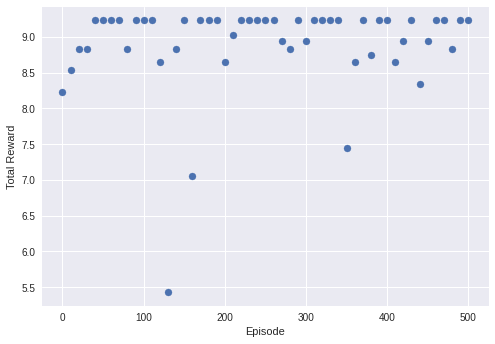

Streaming output truncated to the last 5000 lines.
Episode: 032, Reward:  7.63 Steps:  28 
Episode: 033, Reward:  9.23 Steps:  20 
Episode: 034, Reward:  9.23 Steps:  20 
Episode: 035, Reward:  9.23 Steps:  20 
Episode: 036, Reward:  9.23 Steps:  20 
Episode: 037, Reward:  6.43 Steps:  36 
Episode: 038, Reward:  9.23 Steps:  20 
Episode: 039, Reward:  9.23 Steps:  20 
Episode: 040, Reward:  9.23 Steps:  20 
Episode: 041, Reward:  9.23 Steps:  20 
Episode: 042, Reward:  7.83 Steps:  26 
Episode: 043, Reward:  9.23 Steps:  20 
Episode: 044, Reward:  9.23 Steps:  20 
Episode: 045, Reward:  9.23 Steps:  20 
Episode: 046, Reward:  9.03 Steps:  22 
Episode: 047, Reward:  9.23 Steps:  20 
Episode: 048, Reward:  9.23 Steps:  20 
Episode: 049, Reward:  9.23 Steps:  20 
Episode: 050, Reward:  9.23 Steps:  20 
Episode: 051, Reward:  9.23 Steps:  20 
Episode: 052, Reward:  9.23 Steps:  20 
Episode: 053, Reward:  7.43 Steps:  28 
Episode: 054, Reward:  9.23 Steps:  20 
Episode: 055, Reward:  8.94 S

In [9]:

plt.style.use('seaborn')
plt.scatter(np.arange(0, len(rewards_history), 10), rewards_history[::10])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

for i in range(30):
  rewards_history = agent.train(env,batch_sz=args.batch_size, max_episodes=args.max_eps)
  full_rewards_history.append(rewards_history)
  avg_score, error, best_score, worst_score = agent.model_eval(env)
  print("Average: {:5.2f} | Error: {:5.2f} | Best: {:5.2f} | Worst: {:5.2f} ".format(avg_score, error, best_score, worst_score))


In [10]:
def en_grad(x,y):
  """
  The Potential Energy Surfaces (PES) for a toy 2-dimensional double well problem
  Functional form V(x,y) = A*(x**2 - (x_0)**2) - C*X*Y + 0.5*B*Y**2

  The function returns an energy value and two gradient values of type float.
  """
  C = 1.0
  A = 1.0
  X0 = 1.0
  B = 1.0
  D = 1.0

  X2 = np.square(x)
  Y2 = np.square(y)
  XY = np.multiply(x,y)
  energy = A*np.square(X2-X0*X0)-C*XY+0.5*B*Y2+0.5*D*X2
  dx = 4.0*A*np.multiply(x,X2-X0*X0) - C*y+ D*x
  dy = -C*x + B*y

  dxx = 4.0*A*(X2-X0*X0) + 8.0*A*X2 + D
  dyy = B
  dxy = -C
    
  det = dxx*dyy - dxy*dxy

  tx = dx*(dyy)-dxy*dy
  ty = dx*-dxy + dxx
  return energy, dx, dy

def gradient_descent():
  x0 = -0.001
  y0 = -0.001
  step = 0.1
  xs = np.zeros(100)
  ys = np.zeros(100)
  es = np.zeros(100)
  e,dx,dy = en_grad(x0,y0)
  for i in range(100):
    xs[i] = x0
    ys[i] = y0
    es[i] = e
    e,dx,dy = en_grad(x0,y0)
    print(e,x0,y0,dx,dy)
    x0 -= step*dx
    y0 -= step*dy
    
  
  return xs,ys,es

def coordinate_descent():
  x0 = -0.001
  y0 = -0.001
  step = 0.1
  xs = np.zeros(100)
  ys = np.zeros(100)

  for i in range(100):
    xs[i] = x0
    ys[i] = y0
    e,dx,dy = en_grad(x0,y0)
    if(abs(dx) > abs(dy)):
      x0 -= step*dx
    else:
      y0 -= step*dy
    
  
  return xs,ys

emax = -9.0
emin = 10.0
for i in range (100):
  ep_reward, trajectory = agent.test(env) 
  if i%10 == 0:
    print(i)
  if ep_reward < emin:
    emin = ep_reward
    traj_save_worst = trajectory
  if ep_reward > emax:
    emax = ep_reward
    traj_save_best = trajectory
    
print(emin,emax)




0
10
20
30
40
50
60
70
80
90
5.4300000000000015 9.23


0.9999980000009998 -0.001 -0.001 0.003999996 0.0
0.9999961600059216 -0.0013999996 -0.001 0.005199987824009408 0.00039999960000000005
0.9999930144246243 -0.0019199983824009408 -0.00103999996 0.006799966795722379 0.0008799984224009407
0.999987563482075 -0.0025999950619731787 -0.0011279998022400942 0.008927914684560202 0.0014719952597330845
0.9999780598798347 -0.003492786530429199 -0.0012751993282134027 0.011753388477697094 0.0022175872022157962
0.9999614458368884 -0.004668125378198908 -0.0014969580484349824 0.015500927283184068 0.003171167329763926
0.9999323672614515 -0.006218218106517315 -0.001814074781411375 0.020467767360597647 0.00440414332510594
0.9998814474763366 -0.00826499484257708 -0.0022544891139219692 0.02704721530984236 0.006010505728655111
0.9997922650574538 -0.010969716373561316 -0.0028555396867874804 0.035759408658351165 0.008114176686773836
0.9996360655309952 -0.014545657239396433 -0.0036669573554648643 0.04729161901734093 0.010878699883931569
0.9993625158011593 -0.019274

(-2.0, 2.0)

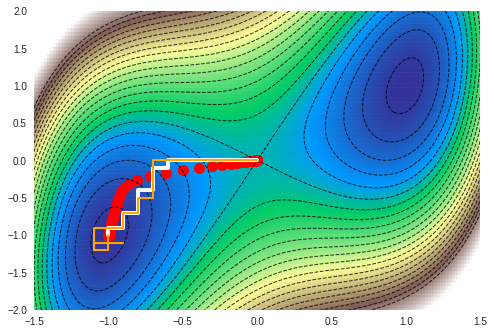

In [11]:
xd, yd, ed = gradient_descent()
print(ed)


x_best=np.zeros(len(traj_save_best))
y_best=np.zeros(len(traj_save_best))
x_worst=np.zeros(len(traj_save_worst))
y_worst=np.zeros(len(traj_save_worst))
count = 0
for t in traj_save_best:
  x_best[count]=t[1][0]
  y_best[count]=t[1][1]
  #e,dx,dy = en_grad(xt[count],yt[count])
  #print(dx,dy)
  count += 1
count = 0
for t in traj_save_worst:
  x_worst[count]=t[1][0]
  y_worst[count]=t[1][1]
#  e,dx,dy = en_grad(xt[count],yt[count])
#  print(dx,dy)
  count += 1
colormap = plt.cm.terrain
size=201
levels = np.linspace(-2.0, 4.0, 33)
x=np.linspace(-2, 2,size)
y=np.linspace(-5, 5,size)
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
e,dx,dy=en_grad(xv,yv)
normalize1 = colors.Normalize(vmin=np.min(e), vmax=5.0)

plt.contour(xv,yv,e,levels=levels,colors=('k',),
                  linewidths=(1,),alpha=0.8,linestyles='dashed')

plt.scatter(xv,yv,c=e,cmap = colormap,norm=normalize1,marker='o',s=20)
plt.scatter(0,0,c='red',s=100)
plt.scatter(xd,yd,linewidth=4,c='red')
plt.plot(x_best,y_best,c='white',linewidth=4)
plt.plot(x_worst,y_worst,c='orange',linewidth=2)

#plt.scatter(xc,yc)
#plt.contourf(xv,yv,e,levels=levels)


plt.xlim(-1.5,1.5)
plt.ylim(-2,2)

In [ ]:
def test_sd():
  x0 = -0.001
  y0 = -0.001
  step_size = 0.01
  count = 0
  size = 20
  xs = np.zeros(size)
  ys = np.zeros(size)
  while count < size:
    move = random.randint(0,3)
    e,dx,dy = en_grad(x0,y0)
    xold = x0
    yold = y0
  #  if dir == dx:
  #    move = 0
  #  else:
  #    move = 3
    if move == 0:
      x0 -= step_size
    if move == 1:
      x0 += step_size
    if move == 2:
      y0 += step_size
    if move == 3:
      y0 -= step_size

    e1, dx1, dxy1 = en_grad(x0,y0)


    if (dx > 0) and (move <=1):
      xs[count] = x0
      ys[count] = y0
      count += 1
    elif (dy > 0) and (move > 1):
      xs[count] = x0
      ys[count] = y0
      count += 1           # print(move,xold,yold,dx1-dx,dy1-dy)
    
    else:
      #print(move)
      if move == 0:
        x0 += step_size
      if move == 1:
        x0 -= step_size
      if move == 2:
        y0 -= step_size
      if move == 3:
        y0 += step_size     

  return xs,ys



In [ ]:
xm,ym = test_sd()
plt.scatter(xd,yd,linewidth=4,c='red')
plt.scatter(xm,ym)

KeyboardInterrupt: ignored

1.0 0.0 0.0 0.0 0.0
0.99982451 -0.01 -0.003 0.032996000000000004 0.007
0.99929816 -0.02 -0.006 0.06596800000000001 0.014
0.9984213099999999 -0.03 -0.009 0.09889200000000001 0.020999999999999998
0.9971945599999998 -0.04 -0.012 0.131744 0.028
0.99561875 -0.05 -0.015 0.16450000000000004 0.035
0.9936949599999999 -0.060000000000000005 -0.018000000000000002 0.19713600000000003 0.042
0.9914245099999999 -0.07 -0.021 0.22962800000000005 0.049
0.98880896 -0.08 -0.024 0.261952 0.056
0.98585011 -0.09 -0.027 0.294084 0.063
0.9825499999999999 -0.09999999999999999 -0.029999999999999995 0.32599999999999996 0.06999999999999999
0.97891091 -0.10999999999999999 -0.032999999999999995 0.35767599999999994 0.07699999999999999
0.97493536 -0.11999999999999998 -0.03599999999999999 0.389088 0.08399999999999999
0.97062611 -0.12999999999999998 -0.03899999999999999 0.4202119999999999 0.09099999999999998
0.9659861600000001 -0.13999999999999999 -0.041999999999999996 0.451024 0.09799999999999999
0.96101875 -0.15 -0.045

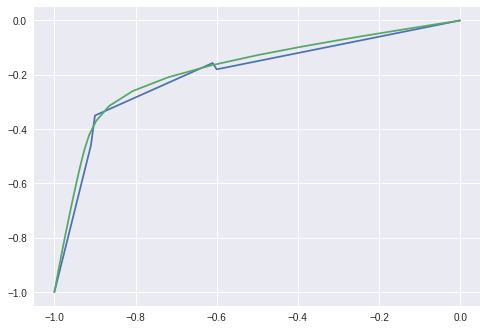

In [ ]:
def gradient_descent():
  x0 = -0.001
  y0 = -0.001
  step = 0.1
  xs = np.zeros(100)
  ys = np.zeros(100)
  es = np.zeros(100)
  dxs = np.zeros(100)
  dys = np.zeros(100)
  e,dx,dy = en_grad(x0,y0)
  for i in range(100):
    xs[i] = x0
    ys[i] = y0
    es[i] = e
    dxs[i] = dx
    dys[i] = dy
    e,dx,dy = en_grad(x0,y0)
    #print(e,x0,y0,dx,dy)
    x0 -= step*dx
    y0 -= step*dy
    
  
  return xs,ys,es,dxs,dys

def gradient_descent_ref():
  x0 = -0.001
  y0 = -0.001
  step = 0.1
  xs = np.zeros(100)
  ys = np.zeros(100)
  es = np.zeros(100)
  dxs = np.zeros(100)
  dys = np.zeros(100)
  e,dx,dy = en_grad(x0,y0)
  er,dxr,dyr = en_grad(y0,x0)
  for i in range(100):
    xs[i] = y0
    ys[i] = x0
    es[i] = er
    dxs[i] = dxr
    dys[i] = dyr
    e,dx,dy = en_grad(x0,y0)
    er,dxr,dyr = en_grad(y0,x0)
    print(e,x0,y0,dx,dy)
    x0 -= step*dx
    y0 -= step*dy
    
  
  return xs,ys,es,dxs,dys


def diagonal_path():
  x0 = 0.0
  y0 = 0.0
  step = 0.01
  xs = np.zeros(100)
  ys = np.zeros(100)
  es = np.zeros(100)
  dxs = np.zeros(100)
  dys = np.zeros(100)
  e,dx,dy = en_grad(x0,y0)
  for i in range(100):
    xs[i] = x0
    ys[i] = y0
    es[i] = e
    dxs[i] = dx
    dys[i] = dy
    e,dx,dy = en_grad(x0,y0)
    print(e,x0,y0,dx,dy)
    x0 -= step
    y0 -= step
    

  return xs,ys,es,dxs,dys


def step_path_offset():
  x0 = 0.0
  y0 = 0.0
  step = 0.02
  xs = np.zeros(100)
  ys = np.zeros(100)
  es = np.zeros(100)
  dxs = np.zeros(100)
  dys = np.zeros(100)
  e,dx,dy = en_grad(x0,y0)
  count = 0
  for i in range(100):
    xs[i] = x0
    ys[i] = y0
    es[i] = e
    dxs[i] = dx
    dys[i] = dy
    e,dx,dy = en_grad(x0,y0)
    print(e,x0,y0,dx,dy)
    if i < 5:
      x0 -= step
    elif i >= 100-5:
      x0 -= step
    else:
      if count >= 10:
        x0 -= step
      else:
        y0 -= step
      count += 1
      if count == 20:
        count = 0
  return xs,ys,es,dxs,dys

def step_path():
  x0 = 0.0
  y0 = 0.0
  step = 0.02
  xs = np.zeros(101)
  ys = np.zeros(101)
  es = np.zeros(101)
  dxs = np.zeros(101)
  dys = np.zeros(101)
  e,dx,dy = en_grad(x0,y0)
  count = 0
  for i in range(101):
    xs[i] = x0
    ys[i] = y0
    es[i] = e
    dxs[i] = dx
    dys[i] = dy
    e,dx,dy = en_grad(x0,y0)
    print(e,x0,y0,dx,dy)
    if count < 10:
      x0 -= step
    else:
      y0 -= step
    count += 1
    if count == 20:
      count = 0
    
  
  return xs,ys,es,dxs,dys


def tangent_path():
  x0 = 0.0
  y0 = 0.0
  step = 0.01
  xs = np.zeros(101)
  ys = np.zeros(101)
  es = np.zeros(101)
  dxs = np.zeros(101)
  dys = np.zeros(101)
  e,dx,dy = en_grad(x0,y0)
  count = 0
  for i in range(101):
    xs[i] = x0
    ys[i] = y0
    es[i] = e
    dxs[i] = dx
    dys[i] = dy
    e,dx,dy = en_grad(x0,y0)
    print(e,x0,y0,dx,dy)
    if i < 60:
      b = 0.3
      inter = 0
      x0 -= step
      y0 = b*x0-inter
    elif i < 90:
      b = 2.0/3.0
      x0 -= step
      y0 = b*x0+0.25
    else:
      b = 6.0
      x0 -= step
      y0 = b*x0+5
    if i == 59:
      inter = y0
    if i == 89:
      inter = y0
      print(inter)
  
  return xs,ys,es,dxs,dys

xm,ym,em,dxs,dys = gradient_descent()
xl,yl,el,dxl,dyl = tangent_path()
plt.plot(xl,yl)
plt.plot(xm,ym)
#plt.plot(xm,dxs)
#plt.plot(xl,dxl)
#plt.plot(ym,dys)
#plt.plot(yl,dyl)
#plt.plot(ym,em)
#plt.plot(yl,el)



#Prelim understanding:
# First derivatives must strictly be > 0 at all points.
# Penalize heavily any path with non zero derivatives

